# SUAS 2025 Mission Area 

https://robonation.gitbook.io/suas-resources/section-3-mission-demonstration#id-3.0.3.-airfield-notes

```text
38.317297, -76.556176
38.315948, -76.556573
38.315467, -76.553762
38.314709, -76.549363
38.314241, -76.546627
38.313698, -76.543423 
38.313310, -76.541096
38.315299, -76.540521
38.315876, -76.543613
38.318616, -76.545385
38.318626, -76.552061
38.317034, -76.552447
38.316742, -76.552945
```


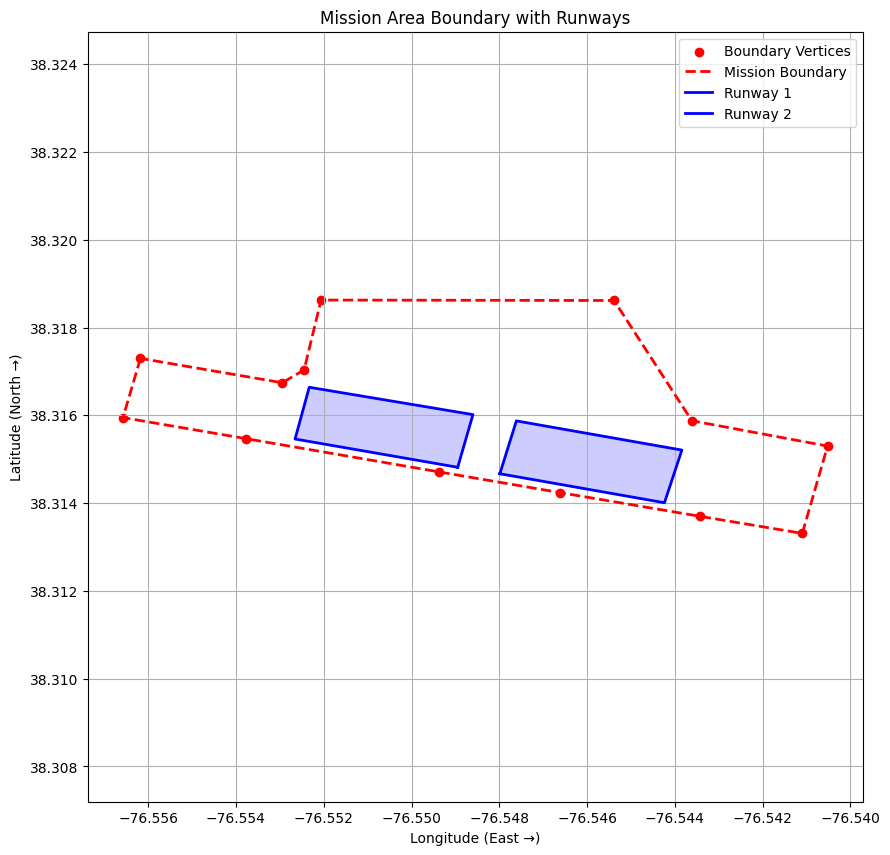

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Main boundary coordinates (unchanged)
coordinates = """
38.317297, -76.556176
38.315948, -76.556573
38.315467, -76.553762
38.314709, -76.549363
38.314241, -76.546627
38.313698, -76.543423 
38.313310, -76.541096
38.315299, -76.540521
38.315876, -76.543613
38.318616, -76.545385
38.318626, -76.552061
38.317034, -76.552447
38.316742, -76.552945
"""

# Runway coordinates
runway1 = """
38.314816, -76.548947
38.315460, -76.552653
38.316639, -76.55233
38.316016, -76.54860
"""

runway2 = """
38.314669, -76.547987
38.315873, -76.547611
38.315208, -76.54384
38.314008, -76.544237
"""

# Parse the coordinates
def parse_coords(coord_str):
    coords = [line.strip().split(',') for line in coord_str.strip().split('\n')]
    lats = [float(coord[0]) for coord in coords]
    lons = [float(coord[1]) for coord in coords]
    # Add first point to close the polygon
    lats.append(lats[0])
    lons.append(lons[0])
    return lats, lons

# Parse all coordinate sets
lats, lons = parse_coords(coordinates)
runway1_lats, runway1_lons = parse_coords(runway1)
runway2_lats, runway2_lons = parse_coords(runway2)

# Create the plot
plt.figure(figsize=(10, 10))

# Plot the main boundary
plt.scatter(lons[:-1], lats[:-1], c='red', marker='o', label='Boundary Vertices')
plt.plot(lons, lats, 'r--', linewidth=2, label='Mission Boundary')

# Plot Runway 1
plt.plot(runway1_lons, runway1_lats, 'b-', linewidth=2, label='Runway 1')
plt.fill(runway1_lons, runway1_lats, alpha=0.2, color='blue')

# Plot Runway 2
plt.plot(runway2_lons, runway2_lats, 'b-', linewidth=2, label='Runway 2')
plt.fill(runway2_lons, runway2_lats, alpha=0.2, color='blue')

# Add labels and title
plt.xlabel('Longitude (East →)')
plt.ylabel('Latitude (North →)')
plt.title('Mission Area Boundary with Runways')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Make aspect ratio equal to prevent distortion
plt.axis('equal')

# Show the plot
plt.show()

## Combine the Matplotlib Plot with the Tiles to for a full interactive map


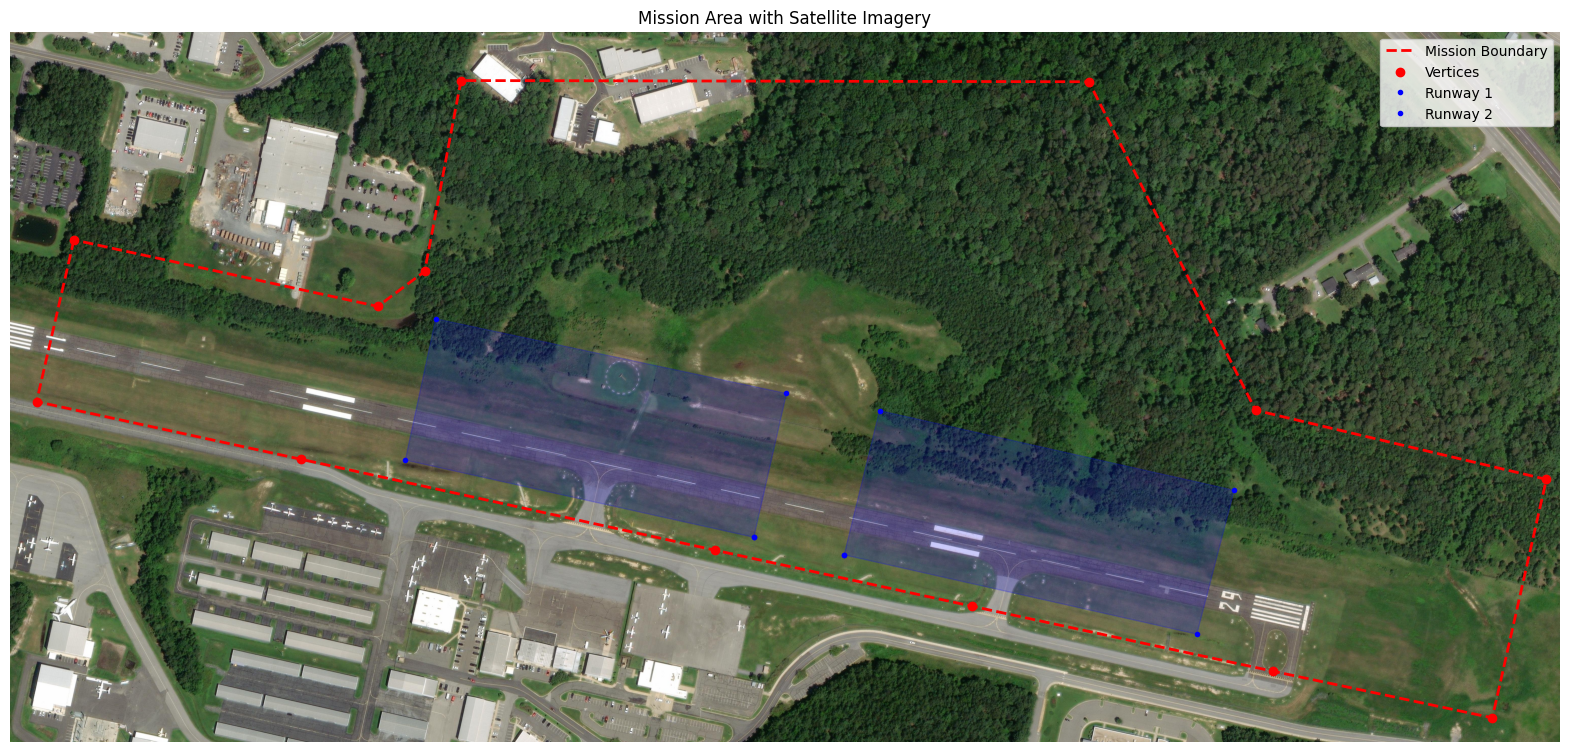

In [21]:
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

def lat_lon_to_tile(lat, lon, zoom):
    # Convert lat/lon to Web Mercator
    x = (lon + 180) / 360
    y = (1 - np.log(np.tan(np.radians(lat)) + 1 / np.cos(np.radians(lat))) / np.pi) / 2

    # Convert Web Mercator to tile coordinates
    n = 1 << zoom  # 2^zoom
    x_tile = int(x * n)
    y_tile = int(y * n)
    
    return (x_tile, y_tile, zoom)

# Get bounding box from our coordinates
min_lat, max_lat = min(lats[:-1]), max(lats[:-1])
min_lon, max_lon = min(lons[:-1]), max(lons[:-1])

zoom = 19
buffer = 0.0001

# Get corner tiles
top_left = lat_lon_to_tile(max_lat + buffer, min_lon - buffer, zoom)
bottom_right = lat_lon_to_tile(min_lat - buffer, max_lon + buffer, zoom)

# Calculate dimensions
tile_width = bottom_right[0] - top_left[0] + 1
tile_height = bottom_right[1] - top_left[1] + 1

# Create a composite image
composite_width = tile_width * 256
composite_height = tile_height * 256
composite = np.zeros((composite_height, composite_width, 3), dtype=np.uint8)

# Load and stitch tiles
for y in range(tile_height):
    for x in range(tile_width):
        tile_x = top_left[0] + x
        tile_y = top_left[1] + y
        
        tile_path = f"area_tiles/map_z{zoom}_y{tile_y}_x{tile_x}.png"
        
        if os.path.exists(tile_path):
            img = cv2.imread(tile_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Calculate position in the composite image
            y_pos = y * 256
            x_pos = x * 256
            
            # Place the tile in the composite image
            composite[y_pos:y_pos+256, x_pos:x_pos+256] = img

# Create figure
plt.figure(figsize=(20, 10))

# Display the composite image
plt.imshow(composite)

# Convert lat/lon to pixel coordinates
def latlon_to_pixels(lat, lon, top_left_tile, zoom):
    n = 1 << zoom
    lat_rad = np.radians(lat)
    
    x = (lon + 180) / 360 * n * 256
    y = (1 - np.log(np.tan(lat_rad) + 1/np.cos(lat_rad)) / np.pi) / 2 * n * 256
    
    # Adjust for our tile offset
    x = x - (top_left_tile[0] * 256)
    y = y - (top_left_tile[1] * 256)
    
    return x, y

# Convert boundary coordinates to pixel coordinates
boundary_pixels = [latlon_to_pixels(lat, lon, top_left, zoom) for lat, lon in zip(lats[:-1], lons[:-1])]
x_pixels, y_pixels = zip(*boundary_pixels)

# Convert runway coordinates to pixel coordinates
runway1_pixels = [latlon_to_pixels(lat, lon, top_left, zoom) for lat, lon in zip(runway1_lats, runway1_lons)]
runway1_x, runway1_y = zip(*runway1_pixels)

runway2_pixels = [latlon_to_pixels(lat, lon, top_left, zoom) for lat, lon in zip(runway2_lats, runway2_lons)]
runway2_x, runway2_y = zip(*runway2_pixels)

# Plot the boundary
plt.plot(x_pixels + (x_pixels[0:1]), y_pixels + (y_pixels[0:1]), 'r--', linewidth=2, label='Mission Boundary')
plt.scatter(x_pixels, y_pixels, c='red', marker='o', label='Vertices')

# Plot Runway 1
plt.plot(runway1_x, runway1_y, 'b.', linewidth=2, label='Runway 1')
plt.fill(runway1_x, runway1_y, alpha=0.2, color='blue')

# Plot Runway 2
plt.plot(runway2_x, runway2_y, 'b.', linewidth=2, label='Runway 2')
plt.fill(runway2_x, runway2_y, alpha=0.2, color='blue')

plt.legend()
plt.axis('off')
plt.title('Mission Area with Satellite Imagery')
plt.show()

In [24]:
# CV2 Image Implementation

import os
import cv2
import numpy as np

def lat_lon_to_tile(lat, lon, zoom):
    # Convert lat/lon to Web Mercator
    x = (lon + 180) / 360
    y = (1 - np.log(np.tan(np.radians(lat)) + 1 / np.cos(np.radians(lat))) / np.pi) / 2

    # Convert Web Mercator to tile coordinates
    n = 1 << zoom  # 2^zoom
    x_tile = int(x * n)
    y_tile = int(y * n)
    
    return (x_tile, y_tile, zoom)

def latlon_to_pixels(lat, lon, top_left_tile, zoom):
    n = 1 << zoom
    lat_rad = np.radians(lat)
    
    x = (lon + 180) / 360 * n * 256
    y = (1 - np.log(np.tan(lat_rad) + 1/np.cos(lat_rad)) / np.pi) / 2 * n * 256
    
    # Adjust for our tile offset
    x = x - (top_left_tile[0] * 256)
    y = y - (top_left_tile[1] * 256)
    
    return int(x), int(y)

# Get bounding box from our coordinates
min_lat, max_lat = min(lats[:-1]), max(lats[:-1])
min_lon, max_lon = min(lons[:-1]), max(lons[:-1])

zoom = 19
buffer = 0.0001

# Get corner tiles
top_left = lat_lon_to_tile(max_lat + buffer, min_lon - buffer, zoom)
bottom_right = lat_lon_to_tile(min_lat - buffer, max_lon + buffer, zoom)

# Calculate dimensions
tile_width = bottom_right[0] - top_left[0] + 1
tile_height = bottom_right[1] - top_left[1] + 1

# Create a composite image
composite_width = tile_width * 256
composite_height = tile_height * 256
composite = np.zeros((composite_height, composite_width, 3), dtype=np.uint8)

# Load and stitch tiles
for y in range(tile_height):
    for x in range(tile_width):
        tile_x = top_left[0] + x
        tile_y = top_left[1] + y
        
        tile_path = f"area_tiles/map_z{zoom}_y{tile_y}_x{tile_x}.png"
        
        if os.path.exists(tile_path):
            img = cv2.imread(tile_path)
            
            # Calculate position in the composite image
            y_pos = y * 256
            x_pos = x * 256
            
            # Place the tile in the composite image
            composite[y_pos:y_pos+256, x_pos:x_pos+256] = img

# Convert coordinates to pixel positions
boundary_pixels = [latlon_to_pixels(lat, lon, top_left, zoom) for lat, lon in zip(lats[:-1], lons[:-1])]
boundary_pixels.append(boundary_pixels[0])  # Close the polygon
boundary_pixels = np.array(boundary_pixels, dtype=np.int32)

runway1_pixels = np.array([latlon_to_pixels(lat, lon, top_left, zoom) for lat, lon in zip(runway1_lats, runway1_lons)], dtype=np.int32)
runway2_pixels = np.array([latlon_to_pixels(lat, lon, top_left, zoom) for lat, lon in zip(runway2_lats, runway2_lons)], dtype=np.int32)

# Draw overlays on the composite
overlay = composite.copy()

# Draw boundary
cv2.polylines(overlay, [boundary_pixels], True, (0, 0, 255), 5)  # Red boundary
for point in boundary_pixels[:-1]:  # Draw vertices
    cv2.circle(overlay, tuple(point), 5, (0, 0, 255), -1)

# Draw runways
cv2.fillPoly(overlay, [runway1_pixels], (255, 0, 0, 128))  # Blue semi-transparent
cv2.fillPoly(overlay, [runway2_pixels], (255, 0, 0, 128))
cv2.polylines(overlay, [runway1_pixels], True, (255, 0, 0), 5)
cv2.polylines(overlay, [runway2_pixels], True, (255, 0, 0), 5)

# Blend the overlay with the original image
alpha = 0.7
result = cv2.addWeighted(composite, alpha, overlay, 1-alpha, 0)

# Create window and set initial size
window_name = 'Mission Area (Mouse wheel to zoom, drag to pan, ESC to exit)'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 960, 540)  # Half of 1080p
# Initial state
scale = 1.0
offset_x = 0
offset_y = 0

def mouse_callback(event, x, y, flags, param):
    global scale, offset_x, offset_y
    
    if event == cv2.EVENT_MOUSEWHEEL:
        old_scale = scale
        
        # Get the mouse position relative to the image
        window_size = cv2.getWindowImageRect(window_name)
        rel_x = (x - offset_x) / scale
        rel_y = (y - offset_y) / scale
        
        # Adjust scale based on mouse wheel
        if flags > 0:  # Zoom in
            scale *= 1.2
        else:  # Zoom out
            scale *= 0.8
        
        # Limit scale
        scale = max(0.1, min(10.0, scale))
        
        # Adjust offset to zoom into mouse position
        offset_x = x - (rel_x * scale)
        offset_y = y - (rel_y * scale)
    
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            # Pan by adjusting offset
            offset_x += (x - param[0])
            offset_y += (y - param[1])
            param[0] = x
            param[1] = y

cv2.setMouseCallback(window_name, mouse_callback, [0, 0])

while True:
    # Get current window size
    window_rect = cv2.getWindowImageRect(window_name)
    if window_rect is None:
        continue
    window_width = window_rect[2]
    window_height = window_rect[3]
    
    # Create display canvas
    display = np.zeros((window_height, window_width, 3), dtype=np.uint8)
    
    # Calculate scaled dimensions
    scaled_width = int(result.shape[1] * scale)
    scaled_height = int(result.shape[0] * scale)
    
    # Calculate visible region
    x1 = max(0, -offset_x / scale)
    y1 = max(0, -offset_y / scale)
    x2 = min(result.shape[1], (window_width - offset_x) / scale)
    y2 = min(result.shape[0], (window_height - offset_y) / scale)
    
    if x1 < x2 and y1 < y2:
        # Extract and scale visible region
        visible = result[int(y1):int(y2), int(x1):int(x2)]
        if visible.size > 0:
            scaled = cv2.resize(visible, 
                              (int((x2-x1)*scale), int((y2-y1)*scale)),
                              interpolation=cv2.INTER_NEAREST)
            
            # Calculate position in display
            disp_x = max(0, min(window_width, int(offset_x + x1*scale)))
            disp_y = max(0, min(window_height, int(offset_y + y1*scale)))
            disp_w = min(window_width - disp_x, scaled.shape[1])
            disp_h = min(window_height - disp_y, scaled.shape[0])
            
            if disp_w > 0 and disp_h > 0:
                display[disp_y:disp_y+disp_h, disp_x:disp_x+disp_w] = \
                    scaled[:disp_h, :disp_w]
    
    cv2.imshow(window_name, display)
    
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break

cv2.destroyAllWindows()


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:536: error: (-27:Null pointer) NULL window: 'Mission Area (Mouse wheel to zoom, drag to pan, ESC to exit)' in function 'cvGetWindowRect_W32'
